In [1]:
# 权重衰减能有效应对过拟合现象（模型的训练误差远小于它在测试集上的误差）
#（增加训练数据集也有可能减轻过拟合，但该过程成本较高）

In [3]:
# 权重衰减等价于（又称为）L2范数正则化(正则化为损失函数添加惩罚项，并使权重参数数值较小）
# 
# 权重衰减是从梯度更新策略的角度来看
# L2范数正则化是从损失函数的角度来看

### 推导过程

以线性回归的损失函数为例，

$$
\ell(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right)^2
$$

其中$w_1, w_2$是权重参数,添加 $L_2$ 范数，有

$$\ell(w_1, w_2, b) + \frac{\lambda}{2n} \|\boldsymbol{w}\|^2,$$

其中权重参数用向量$\boldsymbol{w} = [w_1, w_2]$表示，使用SGD优化算法，更新参数，有

$$
\begin{aligned}
w_1 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_1 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_1^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right),\\
w_2 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_2 -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_2^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right).
\end{aligned}
$$

其中 $L_2$ 范数正则化的作用是使$w$乘一个小于１的值．由于对应权重变小，因此称之为权重衰减．

### 验证过程

模拟拟合一个高维线性回归实验，

$$y = 0.05 + \Sigma_{i=1}^{p=200}{0.01x_i}+\epsilon $$


In [5]:
### 引入相关包，生成数据

In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append('./d2lzh/')
import d2lzh_pytorch as d2l


n_train, n_test, n_features = 20, 100, 200
true_w, true_b = torch.ones(n_features, 1) * 0.01, 0.05  # shape = (200 * 1)
features = torch.randn((n_train + n_test, n_features))   # shape = (120 * 200)
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

# 切割数据
train_features = features[:n_train, :]
test_features  = features[n_train:, :]
train_labels   = labels[:n_train]
test_labels    = labels[n_train:]

### 1. 从零开始

In [2]:
### 1.1 数据准备
batch_size = 1
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [16]:
### 1.2 定义模型和初始化模型参数

In [3]:
net = d2l.linreg

def init_params():
    w = torch.randn((n_features, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

w, b = init_params()

In [18]:
### 1.3 定义惩罚项 和　损失函数

In [4]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

loss = d2l.squared_loss

In [20]:
### 1.4 优化算法

In [5]:
optimizer = d2l.sgd

In [6]:
### 1.5 正式进入训练流程

def fit_and_plot(lambd):
    num_epochs, lr = 100, 0.003
    train_loss, test_loss = [], []
    for _ in range(num_epochs):
        for X, y in train_data_iter:   # X为一批，y为一批．
            ls = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            ls = ls.sum() # 批量的批的意义在于，分批大小来计算loss,而不是每输入一个样本就
                          # 就算一次loss, 就完成一次反向传播，就更新一次参数．
                          # 总而言之，分批是为了加快计算速度（但由于按批次输入，也加重了显存负担）
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            
            ls.backward()
            optimizer([w, b], lr, batch_size)

        train_loss.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_loss.append(loss(net(test_features, w, b), test_labels).mean().item())

    d2l.semilogy(range(1, num_epochs + 1), train_loss, 'epochs', 'loss',
                range(1, num_epochs + 1), test_loss, ['train', 'test'])
    
    print('l2 norm of w:', w.norm().item())

In [ ]:
fit_and_plot(lambd=0)

### 2. pytorch实现

In [8]:
### 对比：
# 数据准备 (一致)
# 定义模型和初始化模型参数（不一致：模型调用nn,初始化调用torch.nn.init.normal_）
# 定义惩罚项 和　损失函数 (不一致：惩罚项放到优化器weight_decay参数定义)
# 优化算法　　（不一致：调用torch.optim.SGD）
# 正式进入训练流程

In [20]:
def fit_and_plot_pytorch(wd, num_Epoches = 100, lr=0.003):
    # 模型
    net = nn.Linear(n_features, 1)
    # 参数初始化
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    # 损失函数
    pass 
    # 优化算法
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    
    # 开始训练
    train_loss, test_loss = [], []
    for _ in range(num_Epoches):
        for X, y in train_data_iter:
            ls = d2l.squared_loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            ls.backward()
            optimizer_w.step()
            optimizer_b.step()
            
        train_loss.append(loss(net(train_features), train_labels).mean().item())
        test_loss.append(loss(net(test_features), test_labels).mean().item())

    d2l.semilogy(range(1, num_Epoches + 1), train_loss, 'epoches', 'loss',
                range(1, num_Epoches + 1), test_loss, ['train', 'test'])
    
    print('L2 norm of w:', net.weight.data.norm().item())


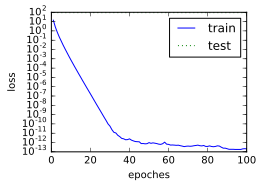

L2 norm of w: 13.37699031829834


In [21]:
# 不加入权重衰减
fit_and_plot_pytorch(0)

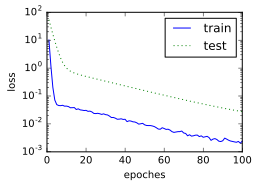

L2 norm of w: 0.059728022664785385


In [22]:
# 加入权重衰减
fit_and_plot_pytorch(5)